<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-data-and-set-environment" data-toc-modified-id="Get-data-and-set-environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get data and set environment</a></span></li><li><span><a href="#read-already-created-train-and-valid-npy-arrays" data-toc-modified-id="read-already-created-train-and-valid-npy-arrays-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>read already created train and valid npy arrays</a></span></li><li><span><a href="#Model-architecture" data-toc-modified-id="Model-architecture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model architecture</a></span></li><li><span><a href="#Compile-and-train" data-toc-modified-id="Compile-and-train-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compile and train</a></span></li><li><span><a href="#Plot-learning-curves" data-toc-modified-id="Plot-learning-curves-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot learning curves</a></span></li><li><span><a href="#Predict-on-subset-of-validation-set" data-toc-modified-id="Predict-on-subset-of-validation-set-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predict on subset of validation set</a></span></li></ul></div>

### Get data and set environment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.io import wavfile
import os
import soundfile as sf
import IPython
import random
import matplotlib.pyplot as plt


from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import models,layers,losses,optimizers,backend,metrics
from tensorflow.keras.layers import Input, Add,Dense, Concatenate,BatchNormalization, Conv1D, Conv1DTranspose, MaxPool1D, Dropout,Flatten
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### read already created train and valid npy arrays

In [ ]:
# train set(s)
train_dataset_o1 = np.load('/content/drive/MyDrive/train_dataset_order1.npy')
train_dataset_o2 = np.load('/content/drive/MyDrive/train_dataset_order2.npy')
train_audio = np.load('/content/drive/MyDrive/train_audio.npy')

In [ ]:
# concat oders if no need to feed separately in model
train_dataset = np.concatenate((train_dataset_o1,train_dataset_o2),axis=2)
train_dataset.shape

(5828, 128, 175)

In [ ]:
#valid set(s)
valid_dataset_o1 = np.load('/content/drive/MyDrive/valid_dataset_order1.npy')
valid_dataset_o2 = np.load('/content/drive/MyDrive/valid_dataset_order2.npy')
valid_audio = np.load('/content/drive/MyDrive/valid_audio.npy')

In [ ]:
valid_dataset = np.concatenate((valid_dataset_o1,valid_dataset_o2),axis=2)
valid_dataset.shape

(1457, 128, 175)

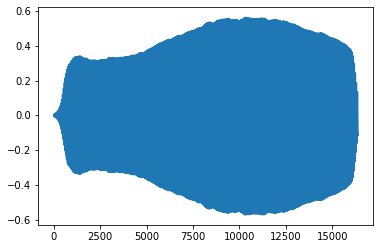

In [ ]:
plt.plot(train_audio[715])

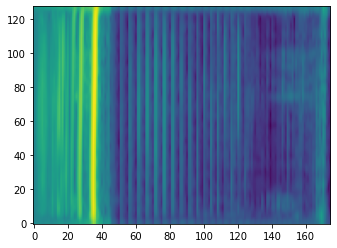

In [ ]:
plt.imshow(np.log(train_dataset[715]),origin='lower')

### Model architecture

In [ ]:
backend.clear_session()

In [ ]:
PARAMS = {'lr': 1e-3,   
          'batch_size': 32,
          'n_epochs': 300,
          'optimizer': 'SGD with momentum',
          'loss': 'custom',
          'metrics': '',
          'activations': 'elu',
          'input_shape' : (128,175),
          'run env' : 'google colab', 
          'data' : 'macaque coos dataset from ESP library.',  
          'save_model': '',
          'notebook' : '',
          'NOTES' : ''
          }

In [ ]:
class CTBN1D(tf.keras.Model):
  def __init__(self, n_filters, kernel, pad,stride=1):
    super(CTBN1D, self).__init__(name='')
    
    self.conv1dT = tf.keras.layers.Conv1DTranspose(n_filters, kernel, strides=stride, padding=pad,activation='elu')
    self.bn = tf.keras.layers.BatchNormalization()


  def call(self, input_tensor):
    x = self.conv1dT(input_tensor)
    x = self.bn(x)
    return x


class Custom_Scalar_Mul(tf.keras.Model):

    def __init__(self):
        super(Custom_Scalar_Mul, self).__init__(name='')

        self.w1 = self.add_weight(shape=[1],
                                initializer = 'random_uniform',
                                trainable=True)

    def call(self,input_tensor):
        return self.w1*input_tensor
    
    
class Scaled_Softsign(tf.keras.Model):

    def __init__(self):
        super(Scaled_Softsign, self).__init__('name')

        self.a = self.add_weight(shape=[1],
                                initializer = 'random_uniform',
                                trainable=True)
        self.b = self.add_weight(shape=[1],
                                initializer = 'random_uniform',
                                trainable=True)

    def call(self,input_tensor):
        return self.a*input_tensor/(1.0 + tf.math.abs(self.b*input_tensor))
    
    

In [ ]:
def Head(in_data,filter_size):
    cT1 = CTBN1D(128,filter_size, pad='same',stride=1)(in_data)
    cT2 = CTBN1D(64,filter_size, pad='same',stride=2)(cT1)
    cT3 = CTBN1D(32,filter_size, pad='same',stride=2)(cT2)
    cT4 = CTBN1D(16,filter_size, pad='same',stride=2)(cT3)
    cT5 = CTBN1D(8,filter_size, pad='same',stride=2)(cT4)
    cT6 = CTBN1D(4,filter_size, pad='same',stride=2)(cT5)
    cT7 = CTBN1D(2,filter_size, pad='same',stride=2)(cT6)
    cT8 = CTBN1D(1,filter_size, pad='same',stride=2)(cT7)
    H1 = Custom_Scalar_Mul()(cT8)
    return H1

In [ ]:
def spectral_convergence(y_true, y_pred):
    #epsilon = 1e-6
    loss1 = tf.norm(tf.math.abs(y_true)-tf.math.abs(y_pred),ord=2)/tf.norm(tf.math.abs(y_true),ord=2)
    #loss2 = tf.norm(tf.math.log(tf.math.abs(y_true) + epsilon) - tf.math.log(tf.math.abs(y_pred) + epsilon),ord=1)
    return loss1  

In [ ]:
filter_size = 13
input_layer=Input(shape=PARAMS['input_shape'])

h1=Head(input_layer,filter_size)
h2=Head(input_layer,filter_size)
h3=Head(input_layer,filter_size)
h4=Head(input_layer,filter_size)
h5=Head(input_layer,filter_size)
h6=Head(input_layer,filter_size)
h7=Head(input_layer,filter_size)
h8=Head(input_layer,filter_size)

NNlayerAdd = tf.keras.layers.Add()([h1, h2, h3, h4, h5, h6, h7, h8])
output= Scaled_Softsign()(NNlayerAdd)

model = Model(inputs=input_layer, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 175)]   0                                            
__________________________________________________________________________________________________
ctb_n1d (CTBN1D)                (None, 128, 128)     291840      input_1[0][0]                    
__________________________________________________________________________________________________
ctb_n1d_8 (CTBN1D)              (None, 128, 128)     291840      input_1[0][0]                    
__________________________________________________________________________________________________
ctb_n1d_16 (CTBN1D)             (None, 128, 128)     291840      input_1[0][0]                    
______________________________________________________________________________________________

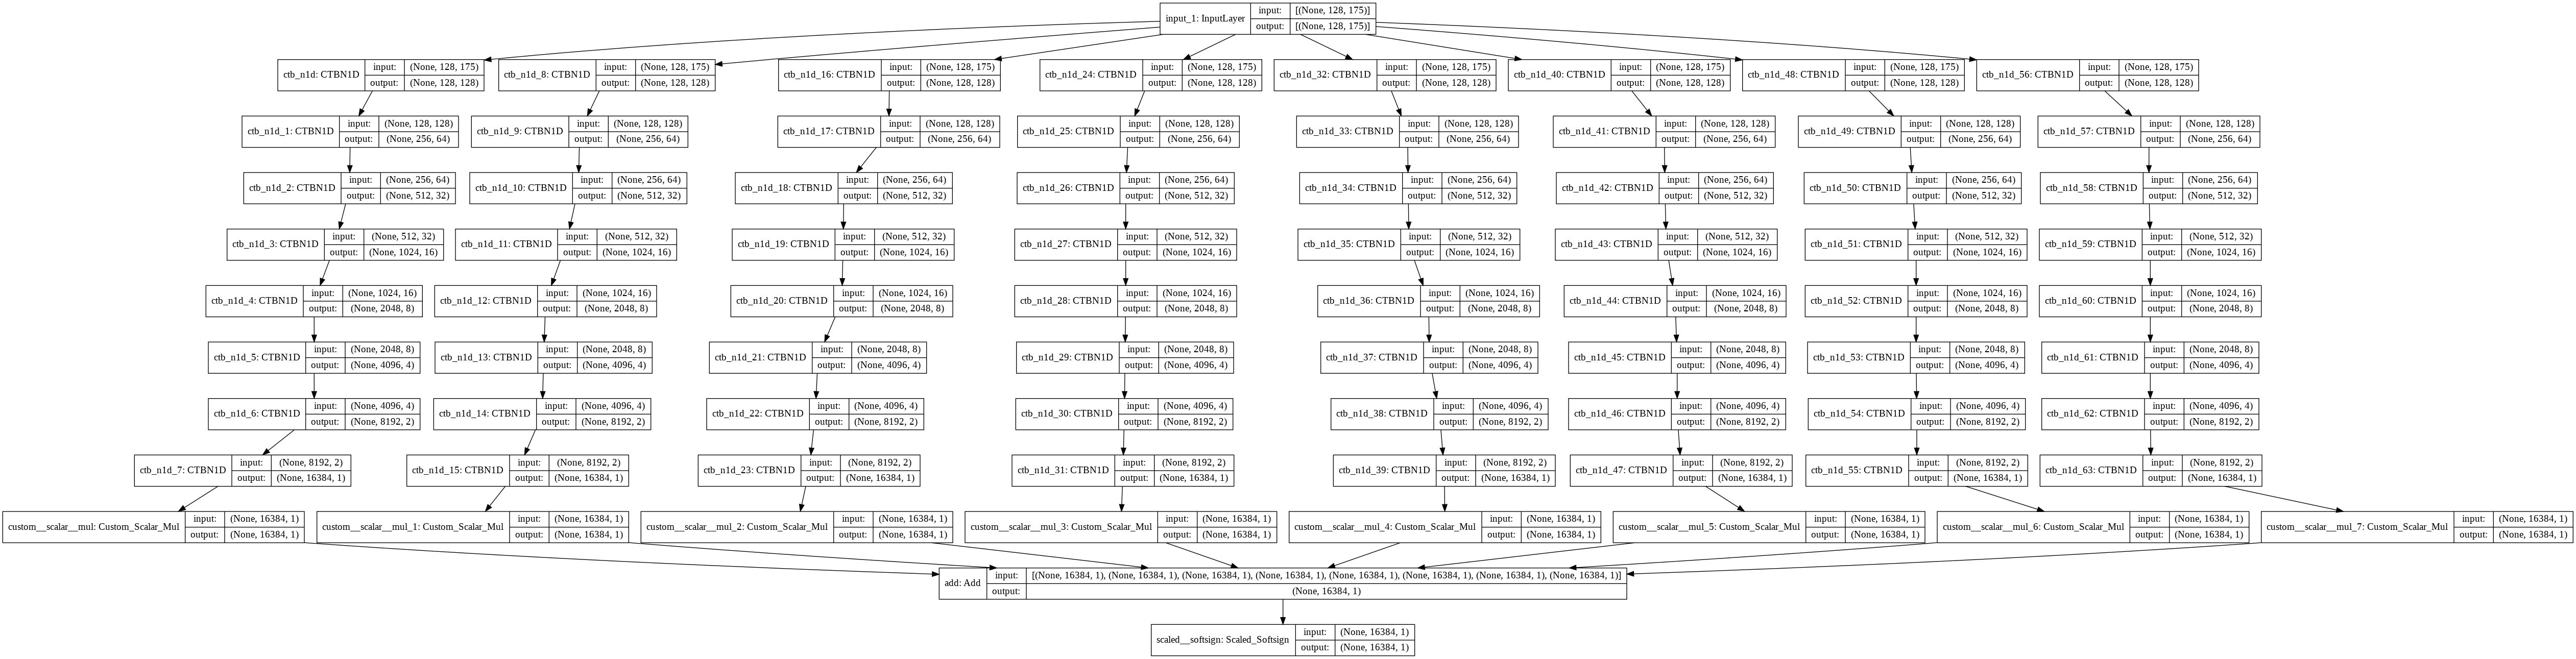

In [ ]:
# create a graph of the model layers
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True,rankdir='TB',show_layer_names=True)

### Compile and train

In [ ]:
model.compile(optimizer=optimizers.SGD(learning_rate=PARAMS['lr'],momentum=0.99,nesterov=True), loss=spectral_convergence)

In [ ]:
history=model.fit(train_dataset,train_audio,
                epochs=PARAMS['n_epochs'],
                shuffle=True,validation_data=(valid_dataset,valid_audio))

#model.save(PARAMS['save_model'])

Epoch 1/300
183/183 [==============================] - 66s 111ms/step - loss: 0.7056 - val_loss: 0.9323
Epoch 2/300
183/183 [==============================] - 19s 104ms/step - loss: 0.5248 - val_loss: 0.9086
Epoch 3/300
183/183 [==============================] - 19s 106ms/step - loss: 0.4937 - val_loss: 0.7591
Epoch 4/300
183/183 [==============================] - 19s 102ms/step - loss: 0.4821 - val_loss: 0.5541
Epoch 5/300
183/183 [==============================] - 19s 103ms/step - loss: 0.4764 - val_loss: 0.4982
Epoch 6/300
183/183 [==============================] - 19s 104ms/step - loss: 0.4720 - val_loss: 0.4870
Epoch 7/300
183/183 [==============================] - 19s 102ms/step - loss: 0.4679 - val_loss: 0.4814
Epoch 8/300
183/183 [==============================] - 19s 102ms/step - loss: 0.4644 - val_loss: 0.4792
Epoch 9/300
183/183 [==============================] - 20s 108ms/step - loss: 0.4631 - val_loss: 0.4775
Epoch 10/300
183/183 [==============================] - 19s 103m

### Plot learning curves

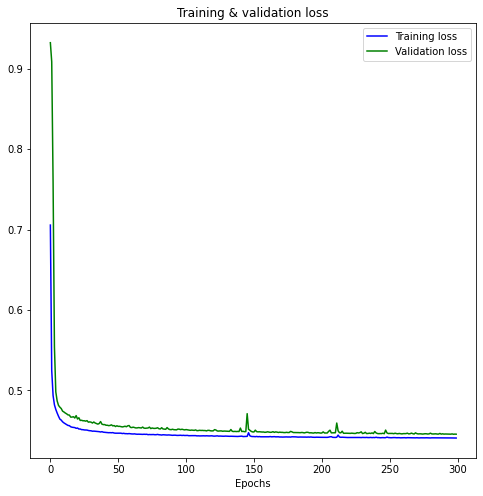

In [ ]:
epoch_num=PARAMS['n_epochs']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8,8))
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')

plt.xlabel('Epochs')
plt.title('Training & validation loss')
plt.legend()
plt.show()

### Predict on subset of validation set

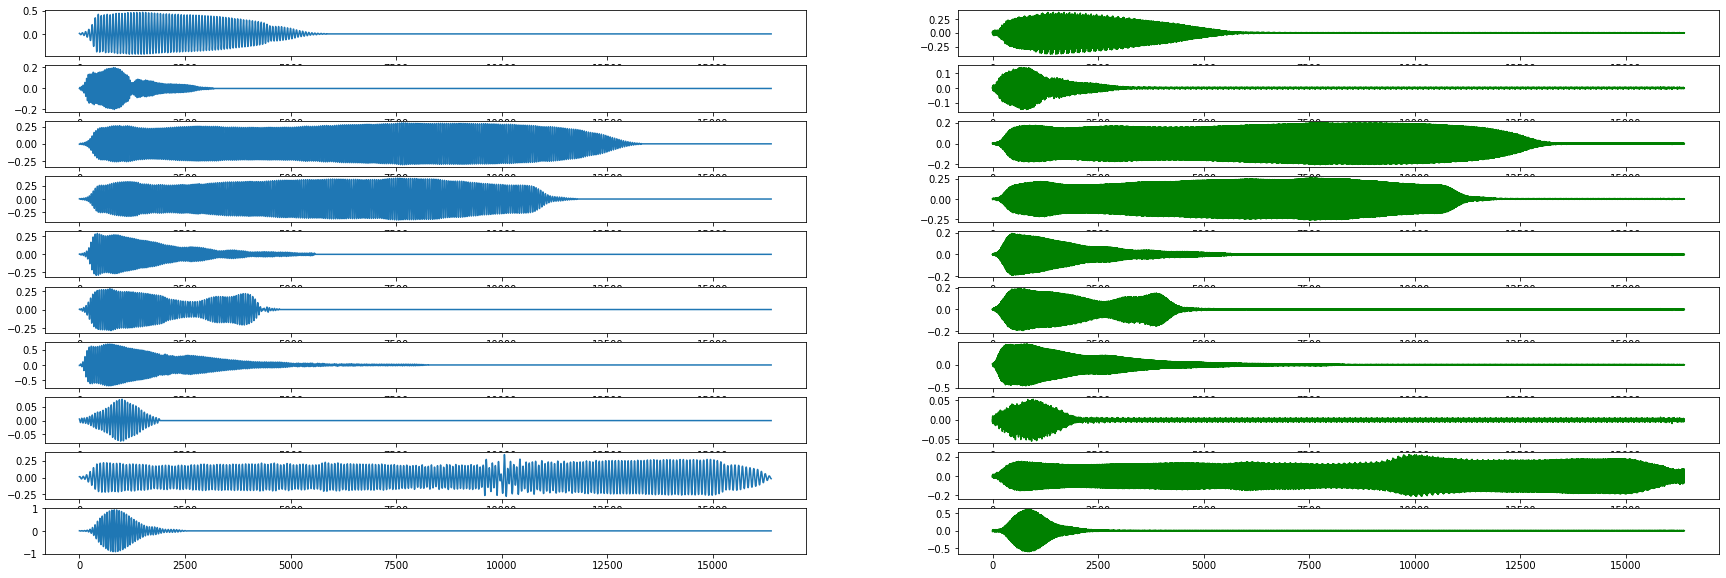

In [ ]:
# choose number of examples from validation set to predict on and compare with original t-series signals


n = 10

orig_audio=[]
decoded_audio=[]
fig,axes=plt.subplots(n,2,figsize=(30,10))
for i in range(n):
    index=random.randrange(len(valid_dataset))
    
    out=model.predict(np.expand_dims(valid_dataset[index],axis=0))
    out=np.squeeze(out,axis=-1)
    out=np.squeeze(out,axis=0)
    audio=valid_audio[index]
    r=i
    ax=axes[r][0]
    ax.plot(audio)
    ax=axes[r][1]
    ax.plot(out,'g')

    orig_audio.append(audio)
    decoded_audio.append(out)
    
plt.show()



In [ ]:
for i in range(n):
    display(IPython.display.Audio(orig_audio[i],rate=24414))
    print('original',i+1)
    display(IPython.display.Audio(decoded_audio[i],rate=24414))
    print('decoded',i+1)

original 1


decoded 1


original 2


decoded 2


original 3


decoded 3


original 4


decoded 4


original 5


decoded 5


original 6


decoded 6


original 7


decoded 7


original 8


decoded 8


original 9


decoded 9


original 10


decoded 10
